# # This notebook shows how to find the lane markings in an image

# Camera Caliberation

./camera_cal/calibration5.jpg---- Corners not found
./camera_cal/calibration4.jpg---- Corners not found
./camera_cal/calibration6.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration1.jpg---- Corners not found
./camera_cal/calibration20.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration8.jpg


Text(0.5,1,'Undistorted Image')

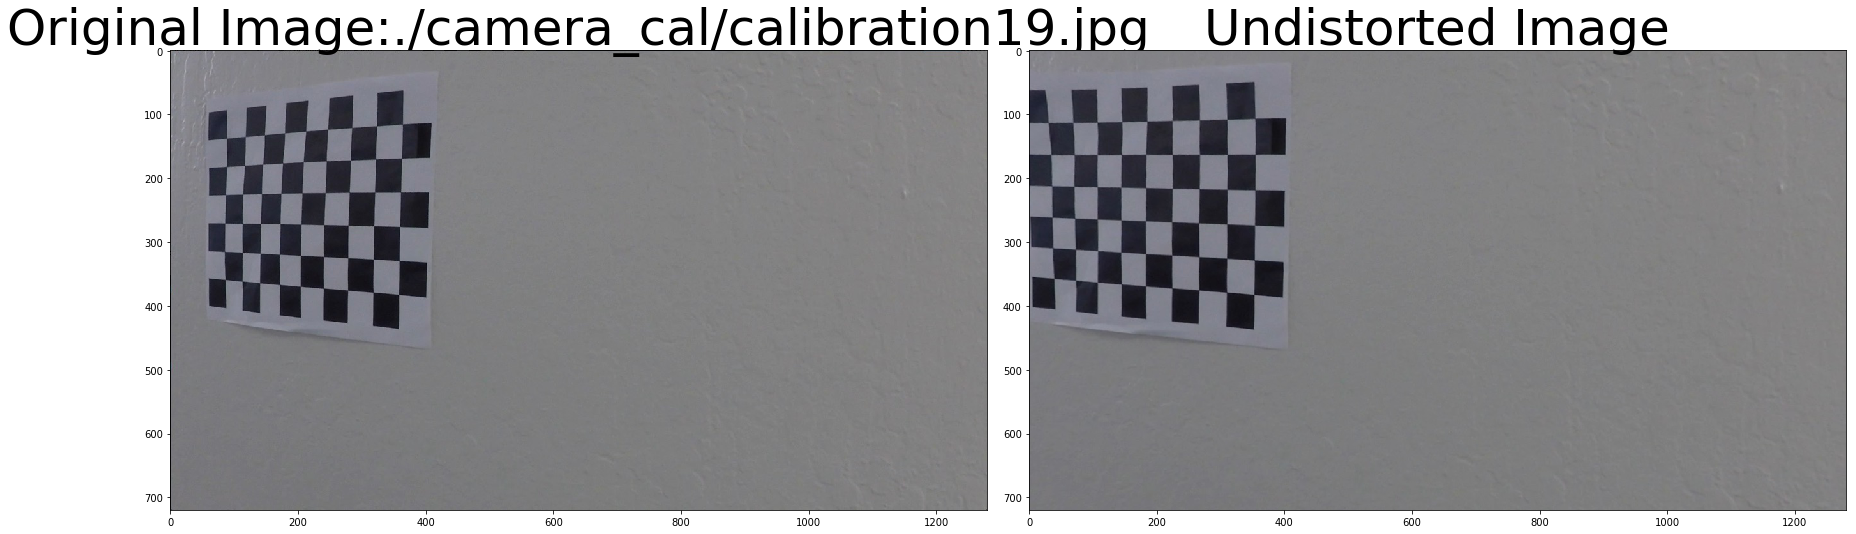

In [1]:
import pickle
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

images = glob.glob('./camera_cal/calibration*.jpg')

object_points = []
image_points = []

one_obj_point = np.zeros((nx*ny, 3), np.float32)
one_obj_point[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

for image_path in images:
    image = mpimg.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_shape = image.shape
    found_corners, corners = cv2.findChessboardCorners(gray_image, (nx,ny), None)
    plot_title=image_path
    if found_corners:
        image_points.append(corners)
        object_points.append(one_obj_point)
        image = cv2.drawChessboardCorners(image, (nx,ny), corners, found_corners)
    else:
        plot_title += "---- Corners not found"
    #plt.figure(figsize=(5,5))
    #plt.title(plot_title)
    #plt.imshow(image)
    print(plot_title)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image_shape[1::-1], None, None)

#Undistorting a sample image
image_file=random.choice(images)
image = mpimg.imread(image_file)
undist = cv2.undistort(image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image:'+image_file, fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)

Text(0.5,1,'Undistorted Image')

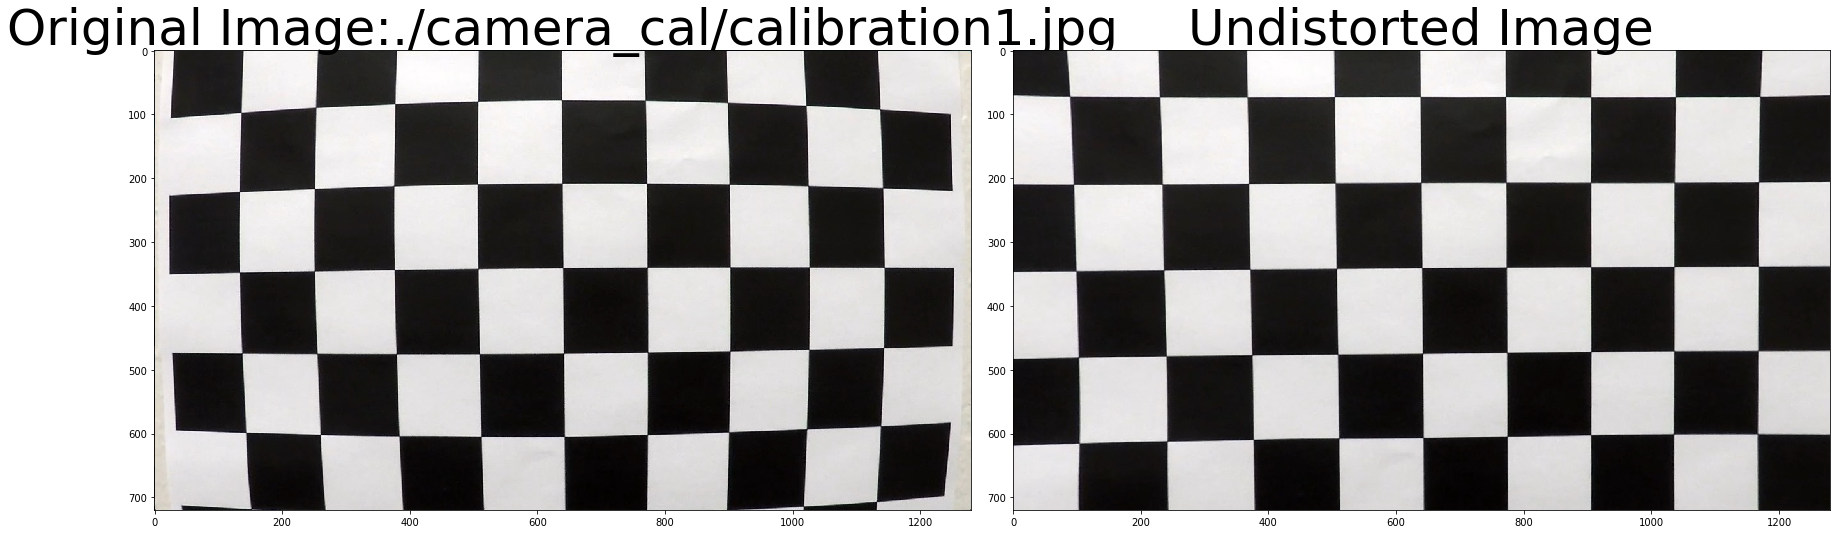

In [2]:
image_file = "./camera_cal/calibration1.jpg"
image = mpimg.imread(image_file)
undist = cv2.undistort(image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image:'+image_file, fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)

In [3]:
import numpy as np

def bird_eye_view(img, corners, offset):
    left_top, right_top, right_bottom, left_bottom = corners
    src = np.float32([left_top, right_top, right_bottom, left_bottom])
    img_size = (img.shape[1], img.shape[0])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return (cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR), M, Minv)

Text(0.5,1,'Undistorted and unwrapped Image')

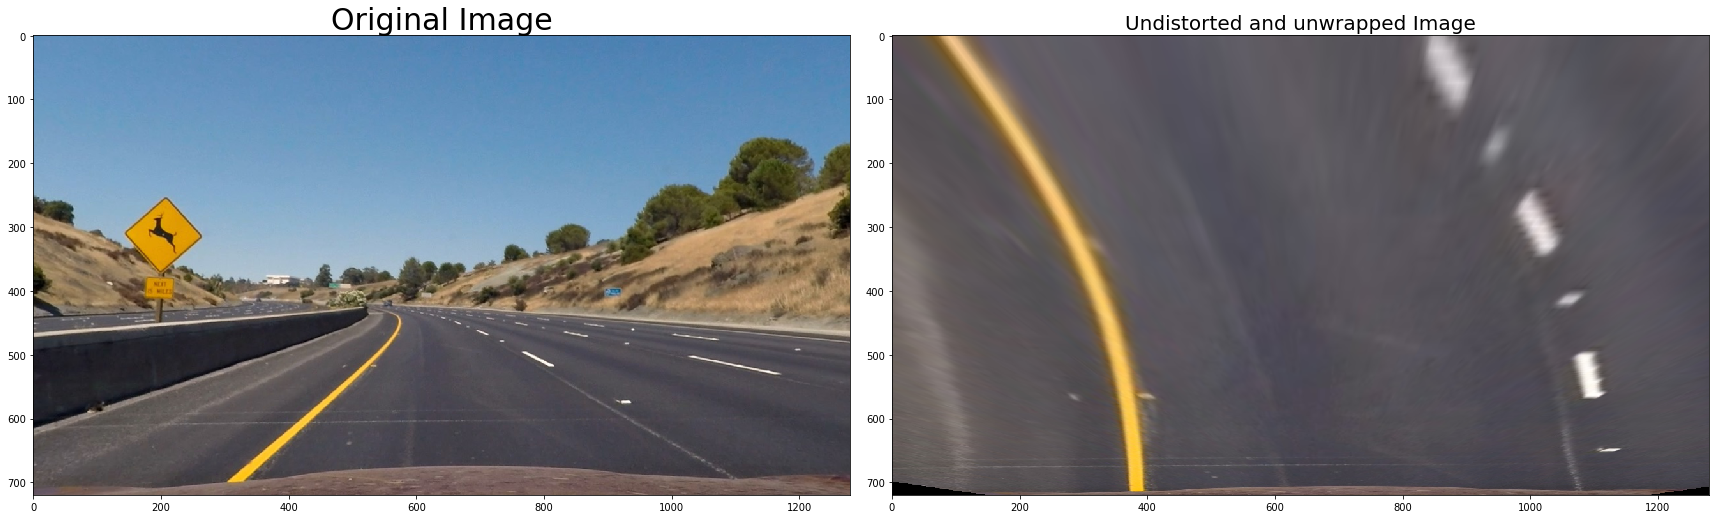

In [4]:

images = glob.glob('./test_images/*.jpg')
images = glob.glob('./test_images/test2.jpg')
#images = glob.glob('camera_cal/calibration2.jpg')

image = mpimg.imread(random.choice(images))
IMAGE_COLOR = cv2.COLOR_RGB2GRAY

#gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#found_corners, corners = cv2.findChessboardCorners(gray_image, (9,6), None)
#image = cv2.drawChessboardCorners(image, (9,6), corners, found_corners)

undist = cv2.undistort(image, mtx, dist, None, mtx)

corners = [[565,450], [709, 450], [1055, 600], [185, 600]]

pts = np.array(corners, np.int32)
pts = pts.reshape((-1,1,2))
#cv2.polylines(undist,[pts],True,(0,255,255))

bird_eye_image, M, Minv = bird_eye_view(undist, corners, 50)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(bird_eye_image)
ax2.set_title('Undistorted and unwrapped Image', fontsize=20)

In [5]:
def bin_output_thresh(sel, thresh):
    binary_output = np.zeros_like(sel)
    binary_output[(sel > thresh[0]) & (sel <= thresh[1])] = 1
    return binary_output
    
def sobel_fun(img, x_dir, sobel_kernel):
    gray = cv2.cvtColor(img,IMAGE_COLOR)
    y_dir = 0 if x_dir==1 else 1
    return cv2.Sobel(gray, cv2.CV_64F, x_dir, y_dir, ksize=sobel_kernel)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    x_dir = 0
    if orient == 'x':
        x_dir = 1
    sobel = sobel_fun(img, x_dir, sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return bin_output_thresh(scaled_sobel, thresh)

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    sobelx = sobel_fun(img, 1, sobel_kernel)
    sobely = sobel_fun(img, 0, sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    return bin_output_thresh(scaled_sobelxy, thresh)

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = sobel_fun(img, 1, sobel_kernel)
    sobely = sobel_fun(img, 0, sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobelxy = np.arctan2(abs_sobely, abs_sobelx)
    return bin_output_thresh(dir_sobelxy, thresh)

def hls_s_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    return bin_output_thresh(s, thresh)

def rgb_r_select(img, thresh=(0, 255)):
    r = img[:,:,0]
    return bin_output_thresh(r, thresh)

def combined_binary(image, kernel_size):
    gradx_bin = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady_bin = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_bin = mag_thresh(image, sobel_kernel=ksize, thresh=(30, 100))
    dir_bin = dir_threshold(image, sobel_kernel=ksize, thresh=(np.pi/8, np.pi/6))
    hls_s_bin = hls_s_select(image, thresh=(180, 255))
    rgb_r_bin = rgb_r_select(image, thresh=(225, 255))

    combined = np.zeros_like(gradx_bin)
    combined[((gradx_bin == 1) | (hls_s_bin == 1) | (rgb_r_bin == 1))] = 1
    #combined[((gradx_bin == 1))] = 1
    #combined[((gradx_bin == 1))] = 1
    #combined[((hls_s_bin == 1))] = 1
    return combined


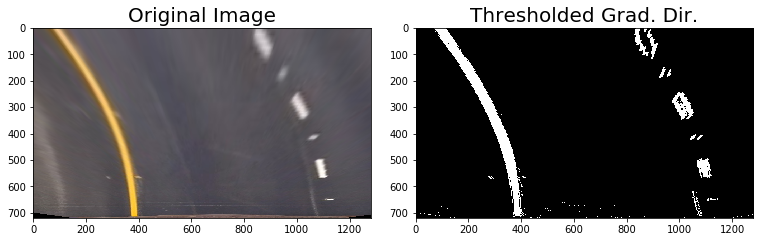

In [6]:
ksize = 3 # Choose a larger odd number to smooth gradient measurements

combined_image = combined_binary(bird_eye_image, ksize)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(bird_eye_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined_image, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

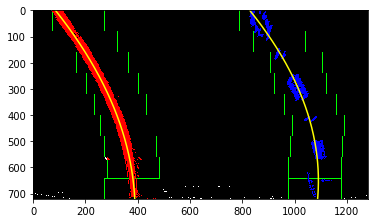

In [7]:
# Choose the number of sliding windows
#nwindows
# Set the width of the windows +/- margin
#margin
# Set minimum number of pixels found to recenter window
#minpix

def locate_lines_fit_polynomial_first(binary_warped, nwindows, margin,
                                      minpix, plot_output_image=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if plot_output_image:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return (left_fit, right_fit, left_fitx, right_fitx, ploty)


# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

left_fit, right_fit, left_fitx, right_fitx, ploty = locate_lines_fit_polynomial_first(
                                                        combined_image,
                                                        nwindows,
                                                        margin, minpix, True)
    

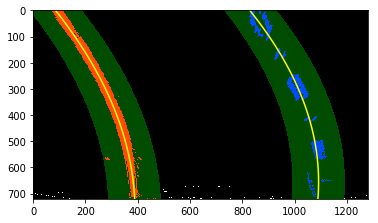

In [8]:
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def locate_lines_fit_polynomial_next(binary_warped, left_fit, right_fit, plot_output_image = False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    if plot_output_image:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return (leftx, rightx, righty, lefty, ploty)

leftx, rightx, righty, lefty, ploty = locate_lines_fit_polynomial_next(combined_image,
                                                                left_fit, right_fit, True)

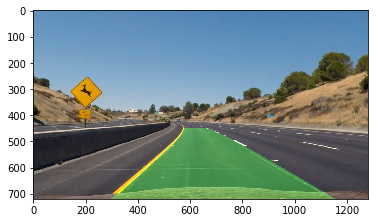

In [9]:
# Create an image to draw the lines on

def color_road(combined_image, image, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(combined_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    return cv2.addWeighted(image, 1, new_warp, 0.3, 0)

plt.imshow(color_road(combined_image, undist, left_fitx, right_fitx, ploty))

In [10]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def calculate_curve(leftx, rightx, ploty):
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = (((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)
                                                                / np.absolute(2*left_fit_cr[0]))
    right_curverad = (((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)
                                                                / np.absolute(2*right_fit_cr[0]))
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

left_curverad, right_curverad = calculate_curve(left_fitx, right_fitx, ploty)
print(left_curverad, 'm', right_curverad, 'm')

# Example values: 632.1 m    626.2 m

318.3082439163108 m 265.9290308057718 m


In [11]:
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
first_run = True

def lane_detect(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    bird_eye_image, M, Minv = bird_eye_view(undist, corners, 50)
    combined_image = combined_binary(bird_eye_image, ksize)
    if first_run:
        left_fit, right_fit, left_fitx, right_fitx, ploty = locate_lines_fit_polynomial_first(
                                                            combined_image, nwindows,
                                                            margin, minpix)
    else:
        locate_lines_fit_polynomial_next(combined_image, left_fit, right_fit)
    colored_image = color_road(combined_image, undist, left_fitx, right_fitx, ploty)
    left_curve_r, right_curve_r = calculate_curve(left_fitx, right_fitx, ploty)
    
    font = cv2.FONT_HERSHEY_COMPLEX
    left_curve_r = 'Left curvature: %f m' % left_curve_r
    right_curve_r = 'Right curvature: %f m' % right_curve_r 
    
    colored_image = cv2.putText(colored_image,left_curve_r,(20,40), font, 1, (255,255,255), 2, cv2.LINE_AA)
    colored_image = cv2.putText(colored_image,right_curve_r,(20,80), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return colored_image

./test_images/test4.jpg


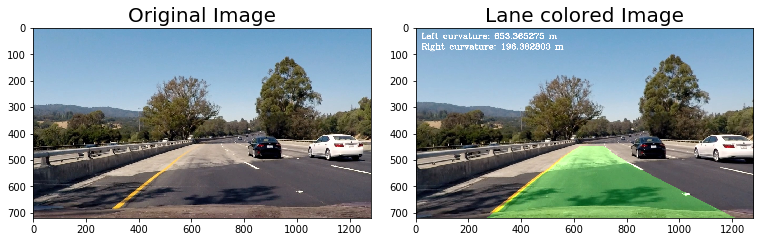

In [ ]:
images = glob.glob('./test_images/*.jpg')
image_file = random.choice(images)
image = mpimg.imread(image_file)
IMAGE_COLOR = cv2.COLOR_RGB2GRAY

lane_colored_image = lane_detect(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image, cmap='gray')
ax2.set_title('Lane colored Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imshow(lane_colored_image)
print(image_file)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

videos = glob.glob('./*.mp4')
first_run = True

for video in videos:
    file_name, ext = os.path.splitext(video)
    if 'output' in file_name:
        continue
    output_video = os.path.join(os.path.dirname(video), file_name+'_output'+ext)
    clip = VideoFileClip(video)
    vid_clip = clip.fl_image(lane_detect)
    %time vid_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ././project_video_output.mp4
[MoviePy] Writing video ././project_video_output.mp4


100%|█████████▉| 1260/1261 [05:13<00:00,  3.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ././project_video_output.mp4 

CPU times: user 4min 41s, sys: 1min 21s, total: 6min 2s
Wall time: 5min 15s
[MoviePy] >>>> Building video ././harder_challenge_video_output.mp4
[MoviePy] Writing video ././harder_challenge_video_output.mp4


 63%|██████▎   | 757/1200 [03:29<02:03,  3.59it/s]